In [11]:
%matplotlib inline

import numpy  as np
import pandas as pd

from sklearn import utils

import matplotlib.pyplot as plt
import seaborn as srn

In [13]:
from sklearn.datasets.mldata import fetch_mldata
import tempfile

%matplotlib inline

from data_fetch import prepare_usps_mlfetch
[Xtrue,Xlabels] = prepare_usps_mlfetch()

data = Xtrue
label = Xlabels
data_train    = data[0:220]
targets_train = label[0:220]
data_test     = data[220:231]
targets_test  = label[220:231]

# test_data_home = tempfile.mkdtemp()
# usps = fetch_mldata('usps', data_home = test_data_home)

[autoreload of data_fetch failed: Traceback (most recent call last):
  File "//anaconda/lib/python3.4/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/Users/men090/Documents/papers/one_class_nn/data_fetch.py", line 11
    print "importing usps from pickle file ....."
                                                ^
SyntaxError: Missing parentheses in call to 'print'
]


HTTPError: HTTP Error 500: Internal Server Error

In [ ]:
# data  = usps.data
# label = usps.target
# data_train    = data[0:220]
# targets_train = label[0:220]
# data_test     = data[220:231]
# targets_test  = label[220:231]

In [4]:
# import pickle
# pickle.dump([ data_train, targets_train, data_test, targets_test ], open('data/usps.pkl', 'wb'))

# data = pickle.load(open('data/usps.pkl', 'rb'))
# print(data[3])

UnicodeDecodeError: 'ascii' codec can't decode byte 0xf0 in position 6: ordinal not in range(128)

## OC-SVM explicit

In [ ]:
def relu(x):
    y = x
    y[y < 0] = 0
    return y

def svmScore(X, w):
    return X.dot(w)

def ocsvm_obj(theta, X, nu, D, g):
    
    w = theta[:D]
    r = theta[D:]
    
    term1 = 0.5 * np.sum(w**2)
    term2 = 1/nu * np.mean(relu(r - svmScore(X, w)))
    term3 = -r
    
    return term1 + term2 + term3

In [ ]:
from scipy.optimize import minimize

X  = data_train
D  = X.shape[1]
nu = 0.04

np.random.seed(42)
theta0 = np.random.normal(0, 1, D + 1)
res = minimize(ocsvm_obj, theta0, method = 'L-BFGS-B', args = (X, nu, D, g),
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

In [ ]:
plt.hist(svmScore(X[targest_train == +1, :], res.x))
plt.hist(svmScore(X[targest_train == -1, :], res.x))

## OC-NN explicit

We perform PCA to a smaller number of dimensions. This is just to make the optimisation burden lighter.

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 16, svd_solver='full')
pca.fit(data_train)

data_train = pca.transform(data_train)
data_test  = pca.transform(data_test)

Define the OC-NN objective function as per the notes. It accepts the activation g(.) as an argument as well.

In [7]:
def relu(x):
    y = x
    y[y < 0] = 0
    return y

def nnScore(X, w, V, g):
    return g((X.dot(V))).dot(w)

def ocnn_obj(theta, X, nu, D, K, g):
    
    w = theta[:K]
    V = theta[K:K+K*D].reshape((D, K))
    r = theta[K+K*D:]
    
    term1 = 0.5 * np.sum(w**2)
    term2 = 0.5 * np.sum(V**2)
    term3 = 1/nu * np.mean(relu(r - nnScore(X, w, V, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4

Minimise objective explicitly for some small number of hidden units.

In [8]:
from scipy.optimize import minimize

X  = data_train
D  = X.shape[1]
K  = 2
nu = 0.04
g  = lambda x : x
#g  = lambda x : 1/(1 + np.exp(-x))
#g  = lambda x : relu(x)

np.random.seed(42)
theta0 = np.random.normal(0, 1, K + K*D + 1)
res = minimize(ocnn_obj, theta0, method = 'L-BFGS-B', args = (X, nu, D, K, g),
               options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

In [9]:
thetaStar = res.x

wStar = thetaStar[:K]
VStar = thetaStar[K:K+K*D].reshape((D, K))
rStar = thetaStar[K+K*D:]

In [10]:
print(rStar)
print(np.percentile(nnScore(data_train, wStar, VStar, g), q = 100 * nu))

[ -3.30870097e-07]
-2.87063540253e-07


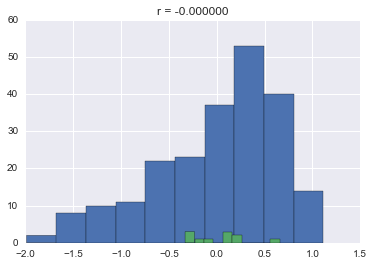

In [11]:
# plt.xlim(-0.002,0.010)
plt.hist(nnScore(data_train, wStar, VStar, g)/rStar);
plt.hist(nnScore(data_test, wStar, VStar, g)/rStar);
plt.title('r = %1.6f' % rStar)